# 1. Import Các thư viện cần thiết

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
#Import Các thư viện Keras và tensorflow để xây dựng CNN
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.models import load_model
import tensorflow
from keras.callbacks import ModelCheckpoint, EarlyStopping


# 2.Xử lý dữ liệu

### Dữ liệu được sử dụng là dữ liệu hình ảnh liên quan đến cảm xúc con người bao gồm nỗi sợ,giận dữ, buồn,vui ,ngạc nhiên bình thường và kinh tởm,ảnh là ảnh đen trắng

### Xem qua một số ảnh của dữ liệu

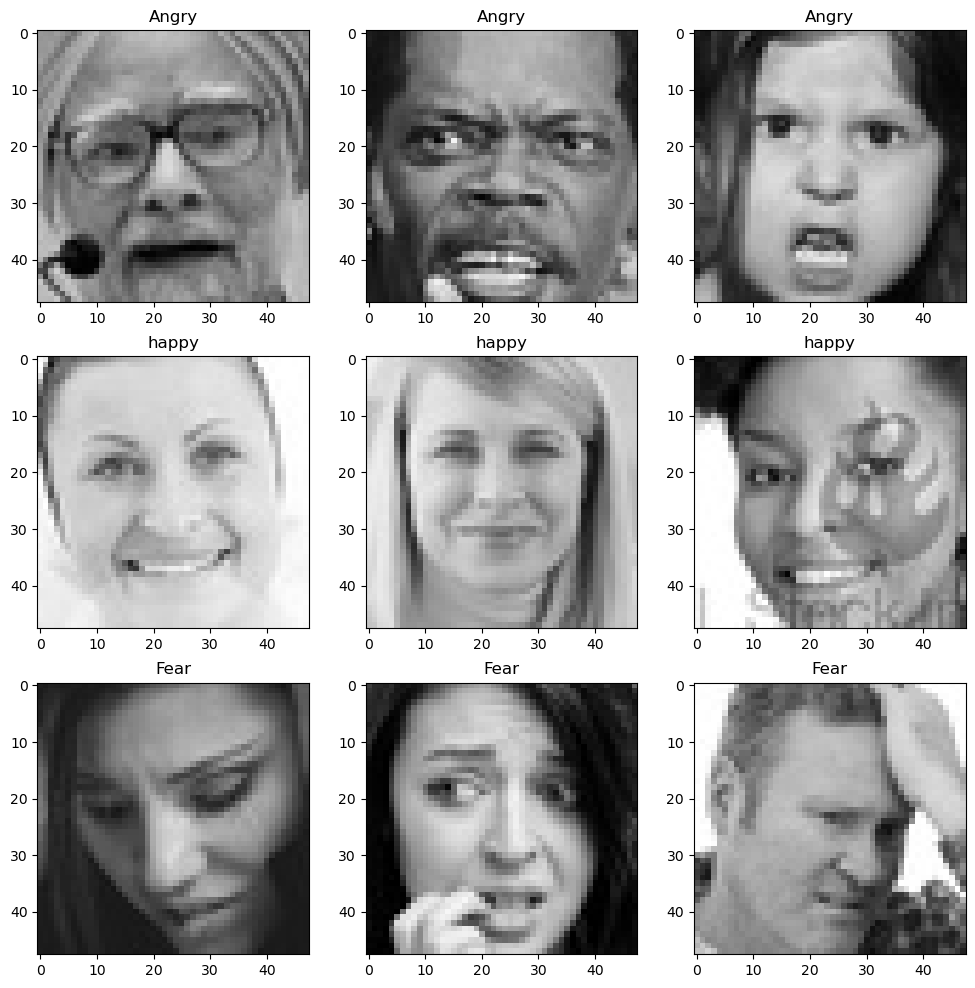

In [47]:
# khởi tạo chiều rộng và chiều dài của ảnh đầu vào là 48
picture_size = 48
# đường dẫn thư mục chứa các dữ liệu
folder_path = "jupyterfile/emotion_data/"
# Show một một số ảnh của hạnh phúc ,tức giận và sợ hãi từ dữ liệu 
expression = ['Angry','happy','Fear']
plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
        j=(i-1)//3
  
        plt.subplot(3,3,i)
        img = cv2.imread(folder_path+"train/"+expression[j]+"/"+
                  os.listdir(folder_path + "train/" + expression[j])[i])
        plt.imshow(img)
        plt.title(expression[j])
plt.show()

### Bắt đầu tạo tập train và tập test cho việc huấn luyện mô hình

In [48]:
#Khởi tạo batch size lớn nhằm đạt độ chính xác cao hơn
batch_size  = 128

#Sử dụng ImageDataGenerator để tăng cường cũng như tạo tập train và tập test

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

# Ảnh đầu vào sẽ có kích thước bằng với biến picture size được gán cho ngay từ lúc bắt đầu

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

#Với tập Train có 28821 bức ảnh thuộc 7 class khác nhau [buồn,vui,bình thường,giận dữ,sợ hãi,kinh tởm ,bất ngờ ]

#Tập test có 7066 bức ảnh 

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# 3.Xây dựng mô hình CNN và train mô hình

In [50]:

# khởi tạo classes bằng 7 tương ứng với 7 cảm xúc phân loại
classes = 7

#khởi tạo Sequential model từ keras để xây dụng CNN
model = Sequential()

#Lớp CNN đâu tiên với số lượng filter là 64 kích thước (3x3) ,với input shape bằng kích thước của ảnh đầu vào 
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#Lớp CNN thứ hai với số lượng filter là 128 kích thước (5x5) 
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#Lớp thứ ba
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#lớp thứ 4
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


#Lớp này sẽ lấy output của các lớp trước đó tạo thành chuỗi 1 chiều sẵn sàng cho các lớp fully conntected
model.add(Flatten())

#Lớp fully connected đầu tiên
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


#Lớp fully connected thứ hai
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# cuối cùng một lớp Dense số lượng unit bằng với số lớp phân loại và sử dụng softmax để lựa chọn lớp có xác suất cao nhất
model.add(Dense(classes, activation='softmax'))


# sử dụng Adam làm optimizer  với learning rate là 0.0001 để dễ hội tụ
opt = Adam(lr = 0.0001)


model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_23 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 24, 24, 128)      

### Tổng cộng Mô hình CNN có 4,478,727 tham số

### sử dụng categorical_crossentropy làm loss function,categorical_crossentropy phù hợp với phân loại đa lớp , categorical_crossentropy đo sự khác biệt giữa phân phối của lớp thực so với với phân phối của lớp dự đoán

In [ ]:

model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

### sử dụng modelcheckpoin để lưu những mô hình trong quá trình train đạt độ chính xác dự đoán trên tập test là cao nhất,sử dụng early stopping để dừng quá trình train khi mô hình không cải thiện val_loss 3 lần liên tục

In [51]:

checkpoint = ModelCheckpoint("model1/modelEmotion.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')


early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )



callbacks_list = [early_stopping,checkpoint]
# train mô hình với 20 epoch
epochs = 20

# Train mô hình

In [25]:
history = model.fit_generator(generator=train_set,
                                steps_per_epoch=train_set.n//train_set.batch_size,
                                epochs=epochs,
                                validation_data = test_set,
                                validation_steps = test_set.n//test_set.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/20


C:\Users\84355\AppData\Local\Temp\ipykernel_23400\3853974908.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_set,


225/225 [==============================] - 269s 1s/step - loss: 1.7694 - accuracy: 0.3237 - val_loss: 1.6569 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - 265s 1s/step - loss: 1.4261 - accuracy: 0.4490 - val_loss: 1.4276 - val_accuracy: 0.4480 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - 265s 1s/step - loss: 1.2748 - accuracy: 0.5124 - val_loss: 1.2521 - val_accuracy: 0.5241 - lr: 0.0010
Epoch 4/20
225/225 [==============================] - 264s 1s/step - loss: 1.1862 - accuracy: 0.5458 - val_loss: 1.1556 - val_accuracy: 0.5520 - lr: 0.0010
Epoch 5/20
225/225 [==============================] - 264s 1s/step - loss: 1.1269 - accuracy: 0.5687 - val_loss: 1.1899 - val_accuracy: 0.5528 - lr: 0.0010
Epoch 6/20
225/225 [==============================] - 265s 1s/step - loss: 1.0801 - accuracy: 0.5874 - val_loss: 1.1575 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 7/20
225/225 [==============================] - 270s 1s/step - loss: 

### plot quá trình tranining của mô hình qua loss và accuracy,Mô hình cho thấy sự cải thiện rất rõ ở tập train cả về loss và accuracy khi đạt được accuracy khoảng trên 65% ,ngược lại Mô hình bị dừng ở epoch 10 mô hình cho thấy sự khó cải thiện ở khoảng 5 epoch chở đi khi đạt được accuracy trên 55%

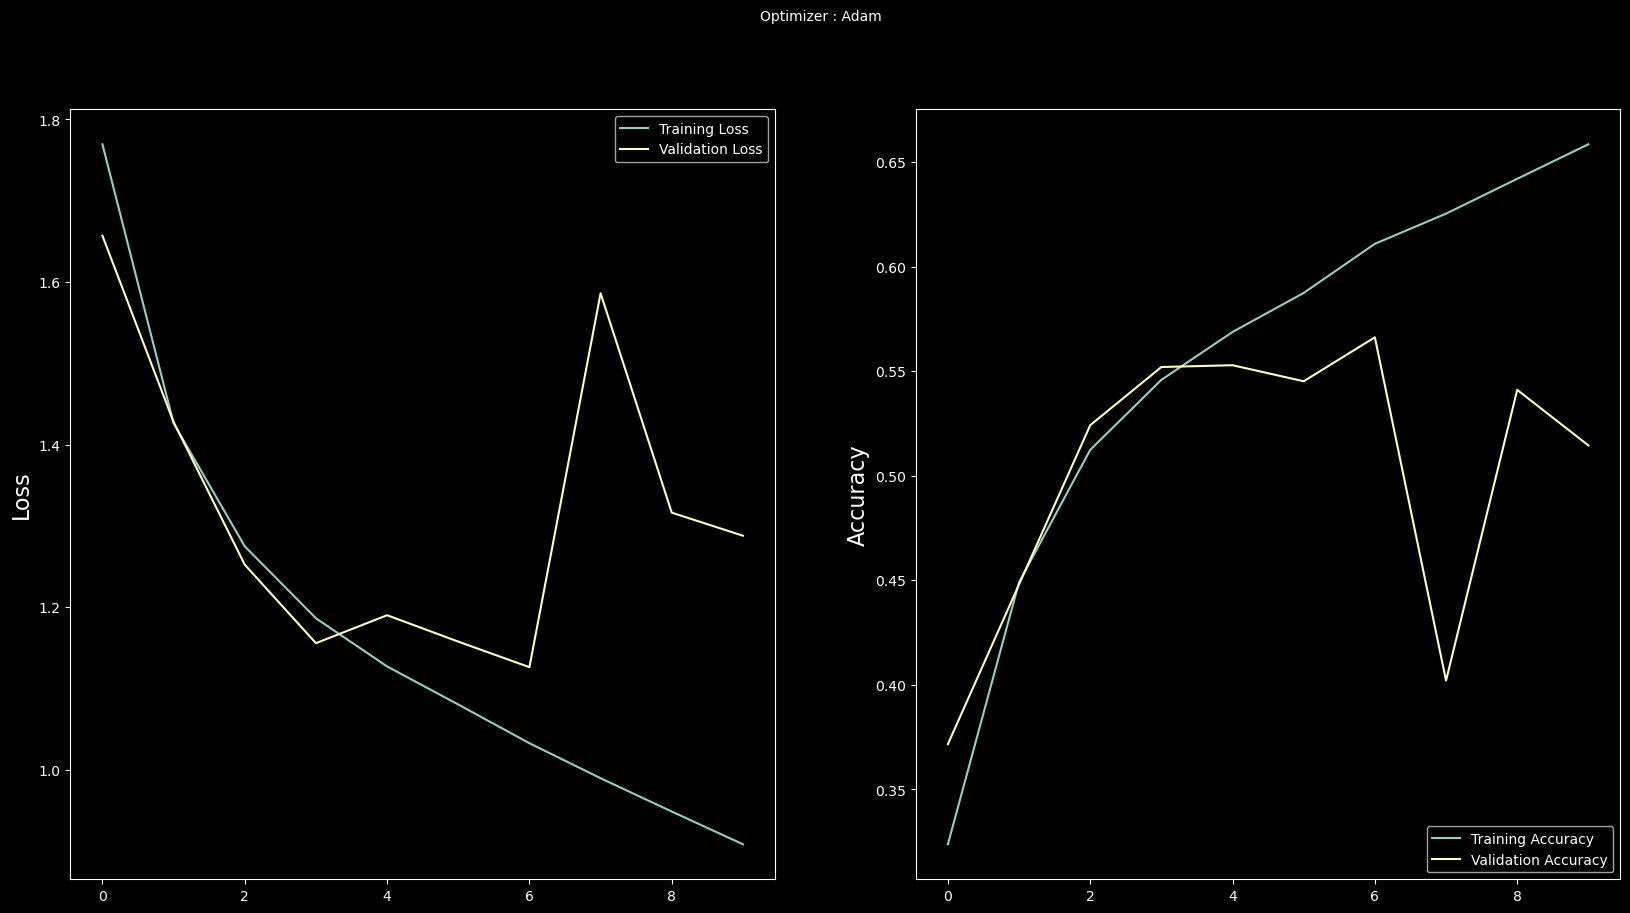

In [26]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()


# 4 Dùng mô hình để dự đoán dữ liệu real time

In [5]:
#khởi tạo các list các nhãn 
labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']


### sử dụng pre trained model từ cv2 để trích xuất khu vực khuôn mặt chính diện có trong frame dưới dạng tọa độ x,y ,chiều dài ,chiều rộng của khu vực đó trong frame

In [ ]:
face_classifier = cv2.CascadeClassifier('jupyterfile/haarcascade_frontalface_default.xml')

### Sử dụng VideoCapture của cv2 để bắt đầu sử dụng dữ liệu real-time từ cam màn hình

In [7]:

vid = cv2.VideoCapture(0)

#Tạo vòng lặp vô hạn cho các frame
while(True):
    #Lấy frame từ cam
    _, frame = vid.read()
    label = []
    
    #chuyển đổi frame sang ảnh trắng đen
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    # trích xuất khu vực khuôn mặt trong frame
    faces = face_classifier.detectMultiScale(gray)

    #sau khi được trích xuất thì cho mỗi khu vực khuôn mặt trích xuất được trong frame ,lấy tọa độ ,chiều dài,chiều rộng
    # của khu vực đó
    for (x,y,w,h) in faces:
        #tách ảnh khu vực khuôn mặt đó trong frame
        roi_gray = gray[y:y+h,x:x+w]
        
        #chỉnh sửa size của ảnh đề phù hợp input của mô hình
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)

            
            #scale ảnh
        roi = roi_gray.astype('float')/255.0
            
            #đưa ảnh về dạng array
        roi = tensorflow.keras.utils.img_to_array(roi)
            
            #ảnh khi này chỉ có dạng là hai chiều gán thêm một chiều nữa để phù hợp với input của mô hình
        roi = np.expand_dims(roi,axis=0)
            
            #Dự đoán xác suất các nhãn cho ảnh từ input trên
        prediction = model.predict(roi)[0]
            
            # lấy nhãn có xác suất cao nhất
        label=labels[prediction.argmax()]
            
            # in nhãn dự đoán ra frame 
        label_position = (x,y)
        cv2.putText(frame,label,(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,244,55),2)
     
    cv2.imshow('Emotion Detector',frame)
    
    #kết thúc quay cam bằng nút o
    if cv2.waitKey(1) & 0xFF == ord('o'):
        break
vid.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


# Kết quả của một số dự đoán real time

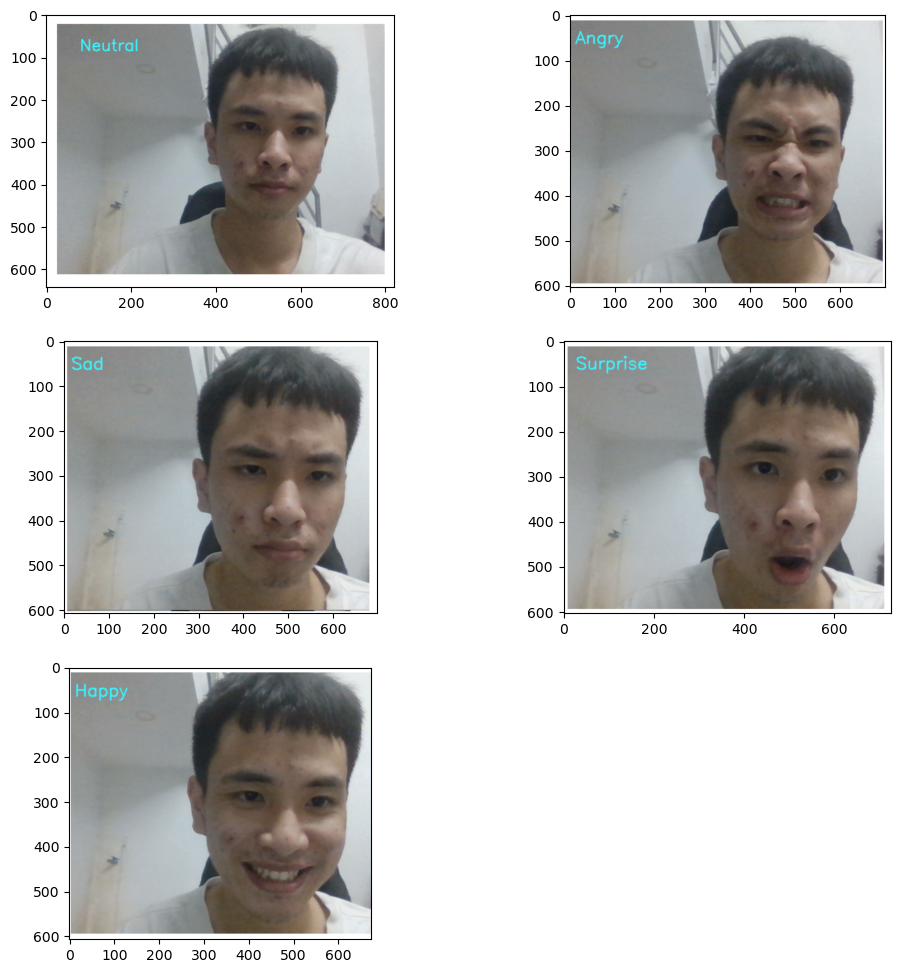

In [16]:

folder_path = "jupyterfile/emotion_data/result/"
plt.figure(figsize= (12,12))
for i in range(1, 6):
        
  
        plt.subplot(3,2,i)
        img = cv2.imread(folder_path+"anh"+f"{i}.png")
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
plt.show()